In [10]:
import random
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 2]

from approach_naive import *
from approach_arima import *
from main.utils.utils import smape

import warnings
warnings.filterwarnings('ignore')

# Technical Report On Time Series Forecast (Challenge 3)

Created by

* Philippe HUET: <Philippe.HUET@student.umons.ac.be> | [source code](https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting/tree/0bce03549bbae572d8d6279c4ff104db993f423c)
* Adam MESZAROS: <Adam.MESZAROS@student.umons.ac.be> | [source code](https://github.com/doodoroma/wiki-hit-time-series-forecast)


*25.01.2021, Belgium*

This report is available on GitHub to be able to open with Google Coolab for better reading experience:
* https://github.com/doodoroma/wiki-hit-time-series-forecast/blob/main/report.ipynb

---

## Understanding the data

The data that is stored in the `train.csv` file contains the number of visit per day on given (unknown) Wikipedia pages. The goal is to be able to predict the visit for the following 21 days.

To be able to understand which method works well and which do not, it is advised to dig into the data to understand its characteristics. Firstly let's display an overall summary of the data sorted by the average hit for the whole period.

In [11]:
data_train = pd.read_csv("train.csv", index_col = "Day", parse_dates = True)
data_train.describe().T.sort_values('mean').head()

,count,mean,std,min,25%,50%,75%,max
series-59,782.0,1188.040921,427.073804,510.0,924.25,1115.0,1347.50,3302.0
series-47,782.0,1332.769821,2126.262587,580.0,1022.50,1178.0,1373.75,56089.0
series-60,782.0,1554.643223,595.707464,636.0,1236.00,1472.0,1731.50,6480.0
series-48,782.0,1658.410486,2752.630094,666.0,1290.00,1472.0,1751.25,75228.0
series-43,782.0,2861.318414,4441.153391,864.0,2001.00,2390.0,2840.50,89266.0


<div style="page-break-after: always;"></div>

### Cleaning 

Not all the pages are the same, the visits vary between thousands and millions. 

The first step is to clean the data to avoid working with information that is not representative. The `clean` method is checking the local differences on the residual to detect and replace the outliers by the surrounding average.

Additionally, to make sure the data is proper, we clip the values below zero (there is no negative visit) and remove the days, where there is a missing information.

In [12]:
data_train_cleaned = (
    data_train
    .apply(clean)
    .apply(clean) # double cleaning!
    .clip(lower = 0)
    .dropna()
)

To have a grasp of the data, let's visualize the first two series

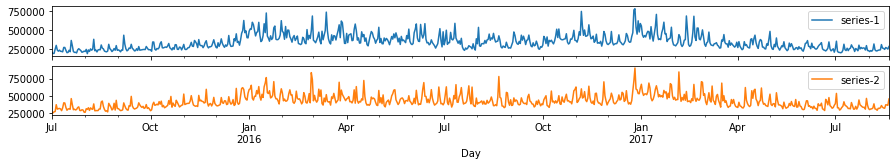

In [13]:
samples = ['series-1', 'series-2']
a = data_train_cleaned[samples].plot(
  subplots=True
)

For the first glance, it seems that the series are not stationary and there is a seasonality in them.

### Seasonality

Intuitively I would presume a periodicity of 7 days, but let's "zoom" in the data and observe a random 2-month period.

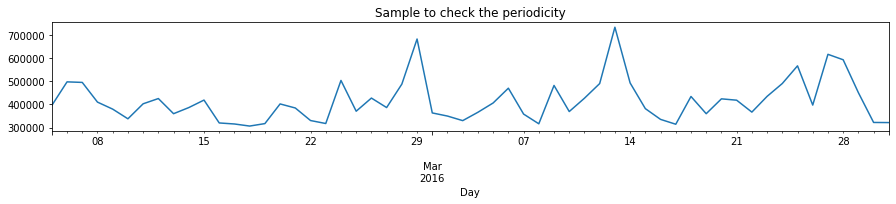

In [14]:
section_size = 7*8
section_start = int(random.random() * (len(data_train) - section_size))
section_end = section_start + section_size
a = (
    data_train['series-1'].iloc[section_start:section_end]
 ).plot.line(
    title='Sample to check the periodicity'
)

It seems that our assumption makes sense. How can we be sure? Let's check the auto-correlation for all the series and check the peaks in the array. If the assumption holds on the distance between peaks shall be `7` as well.

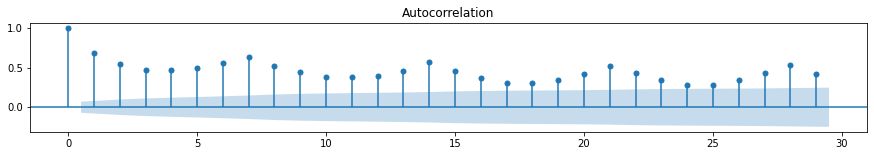

In [15]:
a = plot_acf(data_train['series-1'])

The periodicity of 7 days is visible, but is it true for all the series in the dataset? Let's detect the peaks on the autocorrelation values and calclate on all the series

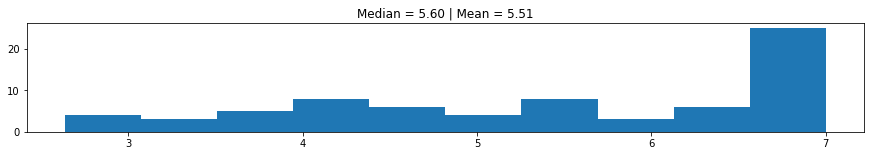

In [16]:
def calculate_period(series_name):
  acf_values = acf(data_train[[series_name]], nlags=40, fft=False)
  peaks, _ = find_peaks(acf_values)
  return np.mean(np.diff(peaks))

periods = [calculate_period(c) for c in data_train.columns]
plt.title(f'Median = {np.median(periods):.2f} | Mean = {np.mean(periods):.2f}')
plt.hist(periods)
plt.show()


Well, the 7-day period seems to be the most common, but it is not clearly true for all the series. It is hard to estimate the period. From the data it seams the 1-week is not always true, but the source of this value might be coming from the society (e.g. people have more time during the weekend) that shall be true for any Wikipedia article. Without knowing more of the topic of the articles, we continue to assume the period to be 7 days.

<div style="page-break-after: always;"></div>

### Check non-stationarity

Stationarity is an important characteristic of the series. From the nature of the data, I presume the series to be stationarity, but due to many external events (for example presidental election) the value can change rapidly in short period, breaking up this property. From the visualization above, we can clearly see that they are not stationary, there are "bumps". To assign a quantitative value to this observation, we used the Augmented Dickey-Fuller unit root test.

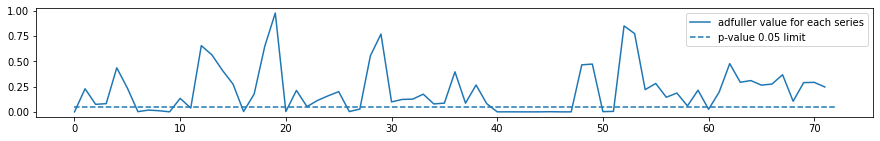

In [17]:
plt.plot([
    adfuller(data_train_cleaned[series_name])[1]
    for series_name in data_train_cleaned.columns
], label='adfuller value for each series', linestyle='-')
plt.hlines(0.05, xmin=0, xmax=len(data_train_cleaned.columns), label='p-value 0.05 limit', linestyle='--')
plt.legend()
plt.show()


We can conclude that even though there are some series that are stationary, this assumption cannot be used for the majority of them.

---

<div style="page-break-after: always;"></div>

## Naive methods

As a first step, we tried the simplest method to see what it can give us. We started off with the naive methods

* "Last value" where we selected the last value from the training set to predict all future date
* "Last average" where we averaged the last couple of values to predict
* "Moving average" where we averaged the last couple of values but recalculated each time a new element is predicted
* "Last season" where we predicted the last period for every future period
* "Last average season" where we calculated the average value of the last couple of periods
* "Last moving average season" where we calculated the average value from the last couple of seasons but we recalclated for each period prediction
* "Drift" method where we predicted the trending on the last couple of (or all) values
* "Decomposite forecast" where we used the "drift" and "last season" on the trend and seasonal component of the series

The source code of the implementations is available on [GitHub](https://github.com/doodoroma/wiki-hit-time-series-forecast/blob/main/utility.py#L36)

Let's see some examples of each method on randomly chosen series.

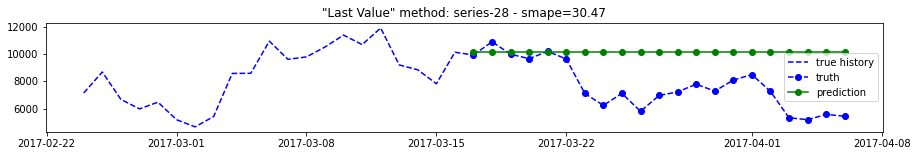

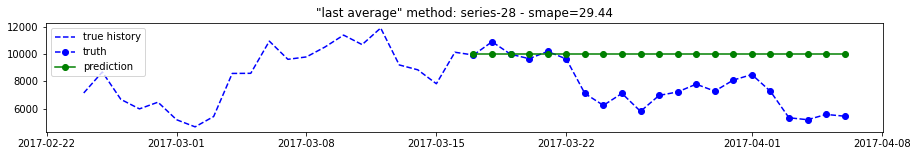

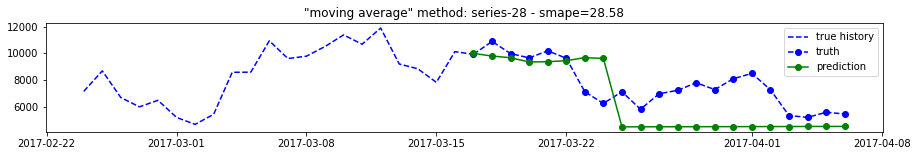

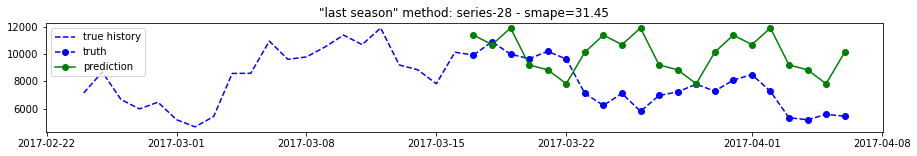

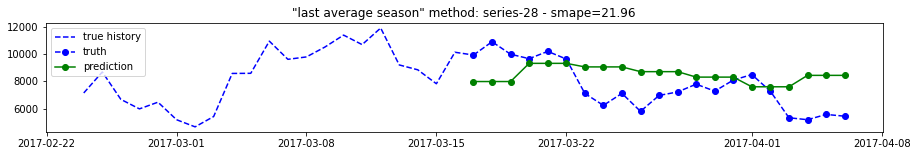

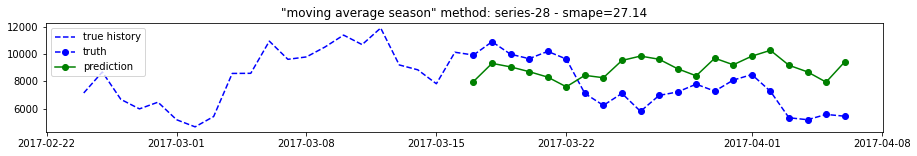

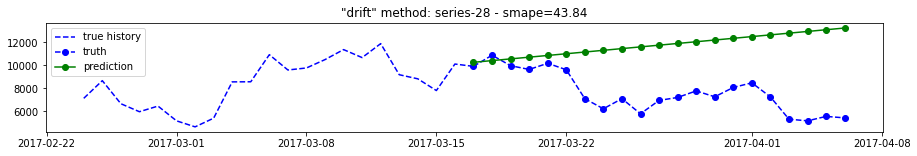

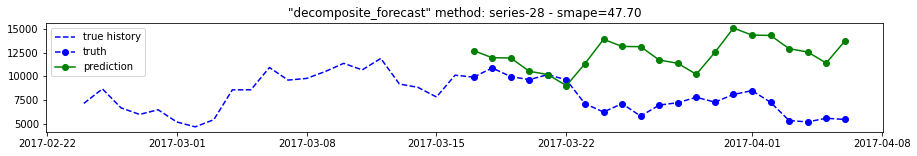

In [18]:
train_size = 0.8
HORIZON = 21
n_train, n_valid = int(len(data_train_cleaned) * train_size), int(len(data_train_cleaned) * (1 - train_size))
series_train, series_valid = (
    data_train_cleaned.iloc[:n_train], 
    data_train_cleaned.iloc[n_train:]
)
series_train_and_valid = data_train_cleaned.iloc[n_train - HORIZON:n_train + HORIZON]
plt.rcParams['figure.figsize'] = [15, 2]
plot_all_methods(series_train_and_valid, series_train, HORIZON)

The question raised what is the best method amongst all the naive approaches. We used the `smape` function to measure the accucracy of the prediction and calculated on all methods and all series. 

<div style="page-break-after: always;"></div>

Let's compare 3 of the methods

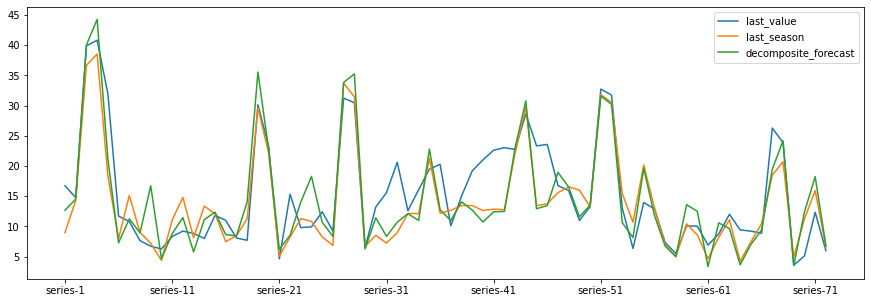

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
methods = [
    (last_value, {}),
    # (last_average, {'history': 7}),
    # (moving_average, {'history': 7}),
    (last_season, {'period': 7}),
    # (last_average_season, {'period': 7, 'history': 3}),
    # (moving_average_season, {'period': 7, 'history': 3}),
    # (drift_method, {'trend_history':None}),
    (decomposite_forecast, {'trend_history':None}),
]
df_accuracy = pd.DataFrame(
    [[
        eval_accuracy(
            y_true=series_valid[series_name][:HORIZON],
            y_pred=naive_forecast(
                series_train, 
                series_name=series_name, 
                method=method,
                HORIZON=HORIZON,
                **args
            ),
            accuracy_measure=smape
        ) 
        for series_name in series_train.columns]
        for method, args in methods
    ], 
    index=[m.__name__ for m,_ in methods],
    columns=series_train.columns
)
a = df_accuracy.T.plot()


<div style="page-break-after: always;"></div>

We used the sum of all the accuracy measures and selected the minimum to determine the "best" method in our arsenal of naive methods. 

In [13]:
methods = [
    (last_value, {}),
    (last_average, {'history': 7}),
    (moving_average, {'history': 7}),
    (last_season, {'period': 7}),
    (last_average_season, {'period': 7, 'history': 3}),
    (moving_average_season, {'period': 7, 'history': 3}),
    (drift_method, {'trend_history':None}),
    (decomposite_forecast, {'trend_history':None}),
]
overall_accuracy = [
    np.sum([
        eval_accuracy(
            y_true=series_valid[series_name][:HORIZON],
            y_pred=naive_forecast(
                series_train, 
                series_name=series_name, 
                method=method,
                HORIZON=HORIZON,
                **args
            ),
            accuracy_measure=smape
        ) 
        for series_name in series_train.columns
    ])
    for method, args in methods
]
best_method_idx = np.argmin(overall_accuracy)
print('Best naive method is')
print(f'"{methods[best_method_idx][0].__name__}" Σ smape =', overall_accuracy[best_method_idx])

Best naive method is
"last_season" Σ smape = 998.116796526697


It turned out to be the "last season" which simply predicts the last season for the next 21 days (3 seasons).

`"last_season" Σ smape = 998.116796526697`

Interestigly the "Decomposite forecast" method didn't give better result, even though we showed at the beginning that the stationarity is not true for all the series. We concluded that this is because the trending is not monotonic nor linear.

---

<div style="page-break-after: always;"></div>

## ARIMA

ARIMA is an acronym for **A**uto**r**egressive **i**ntegrated **m**oving **a**verage

We tried out the package of [pmdarima](http://alkaline-ml.com/pmdarima/) that is capable of constructing the best ARIMA model in a given range. The model can accept a range for the order of `p` and `q` as well as for the `P` and `Q` (seasonal). 

Some considerations:

* The model shall have seasonal data 
* The period should be `7`

Let's see three examples of a given series' ARIMA model. The first is not using any seasonal elements (`P = Q = 0`). It is visible that the prediction is more-or-less constant, there is no seasonal information. The second is a simple (lower order) but already seasonal model. In the visualization it is easy to see that the predicted values are much closer and the `smape` value is better. Finally, we show a version where the model is more complex, but the predicted results - for this given example - is better.

The source code, that creates the model is available on [GitHub](https://github.com/doodoroma/wiki-hit-time-series-forecast/blob/main/approach_naive.py#L36)

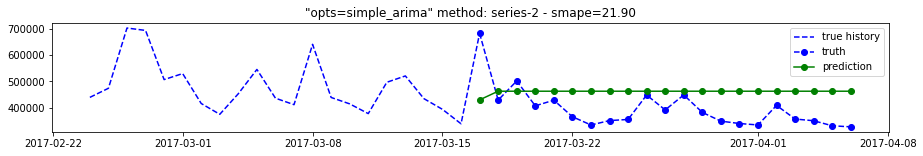

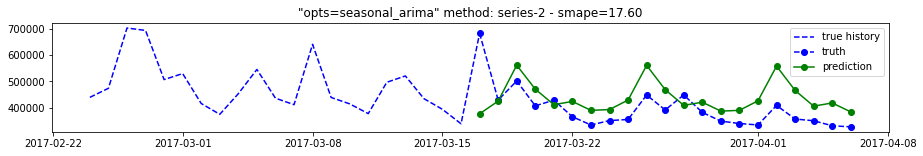

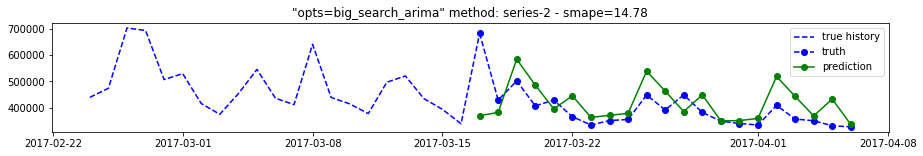

In [32]:
for opt in [
    { 'name': 'simple_arima', 'seasonal': False },
    { 'name': 'seasonal_arima', 'seasonal': True, 'min_p': 0, 'max_p': 2, 'min_q': 0, 'max_q': 2, 'min_P': 0, 'max_P': 1, 'min_Q': 0, 'max_Q': 1 },
    { 'name': 'big_search_arima', 'seasonal': True, 'min_p': 2, 'max_p': 5, 'min_q': 2, 'max_q': 5, 'min_P': 2, 'max_P': 5, 'min_Q': 2, 'max_Q': 5 },
]:
    [
        plot_eval(
            y_true=series_train_and_valid[series_name],
            y_pred=arima_forecaset(
                series_train, 
                series_name=series_name, 
                HORIZON=HORIZON,
                **opt
            ),
            method_name = f'opts={opt["name"]}' ,
            accuracy_measure=smape
        ) for series_name in itertools.islice(series_train.columns, 1, 2)
    ]

<div style="page-break-after: always;"></div>

Let's calculate the overall accuracy similar to the naive method. This way we can compare it with the previously demonstrated naive approach.

In [ ]:
opts = [
  # { 'name': 'non_seasonal', 'seasonal': False },
  { 'name': 'big_search_arima', 'seasonal': True, 'min_p': 2, 'max_p': 4, 'min_q': 2, 'max_q': 4, 'min_P': 2, 'max_P': 3, 'min_Q': 2, 'max_Q': 3 }
]
series_columns = series_train.columns #list(itertools.islice(series_train.columns, 1, 3))
df_accuracy = pd.DataFrame([[
    eval_accuracy(
        y_true=series_valid[series_name][:HORIZON],
        y_pred=arima_forecaset(
            series_train, 
            series_name=series_name, 
            HORIZON=HORIZON,
            **opt
        ),
        accuracy_measure=smape
    ) 
    for series_name in series_columns]
    for opt in opts 
  ],
  index=[opt['name'] for opt in opts],
  columns=series_columns
)

In [28]:
df_accuracy = pd.read_csv('arima_accuracy.csv', index_col=0)

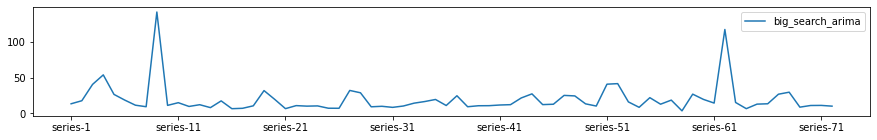

In [33]:
a = df_accuracy.T.plot()

In [26]:
acc = df_accuracy.T.sum()[0]
print(f'ARIMA Σ SMAPE = {acc}')

ARIMA Σ SMAPE = 1415.3546538235678


### Conclusion

Surpirsingly, the ARIMA models perform worse compare to the naive method, even if the model is allowed to be complex

One important aspect shall be mentioned, that to scan all the combinations of the ARIMA models takes a significant amount of time. 

---

<div style="page-break-after: always;"></div>

## Time Series Forecasting with Neural Networks

We have built different types of NN models for time series forecasting covering forecasts for a single time step as well as for multiple steps. Our study includes linear, dense, CNN, RNN models, as well as a convolutional se2seq neural network modeled after WaveNet. 

As our main objective was to learn more on how to build these networks using Tensoflow/Keras and how to transform the time series dataset to train and predict, we have decided to fuly develop these models from scratch without using the code made available to us during the exercise sessions. The code of all our models is available on [github](https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting) in the folder [src_neural_network](https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting/tree/main/src_neural_network). 

Our work is based on these two excellent publications:
 
*   [TensorFlow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
*   [JEddy32's TimeSeries_Seq2Seq](https://github.com/JEddy92/TimeSeries_Seq2Seq)

### Simple multi steps models
We have built several simple models to make multiple time step predictions. These models make "single shot predictions" where the entire period is predicted at once (i.e. 21 days). These models predict also all features (series) at once. The code is avalaible in the class [MultiStepModels](https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting/blob/main/src_neural_network/multiStepModels/MultiStepModels.py). As a example, here are the Dense and CNN models:

In [ ]:
def model_dense(self):
    multi_dense_model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(MS_OUT_STEPS*self.num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([MS_OUT_STEPS, self.num_features])
    ])

    history = compile_and_fit(multi_dense_model, self.multi_window)

def model_cnn(self):
    CONV_WIDTH = 3
    multi_conv_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(MS_OUT_STEPS*self.num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([MS_OUT_STEPS, self.num_features])
    ])

    history = compile_and_fit(multi_conv_model, self.multi_window)

The plots below show the predictions over the course of 21 days for a few arbitrary series. The green dots show the target prediction values (labels), the orange dots shows the actual prediction:

| Dense Model | CNN Model |
|---|---|
|![title](https://drive.google.com/uc?export=view&id=1t7En_1lkawq5wLvyVuMnwdT0o7r4Kafz)|![title](https://drive.google.com/uc?export=view&id=1b4r63S_3LKsDKT5Frp0DvzhGAOZCwpEk)

These models look to do a good job picking up on seasonality and trend, and handling the prediction horizon for many series. But the Kaggle scores are disapointing: around 17.5. So, we decided to focus on a more promising network: an autoencoder model using DeepMind's WaveNet concepts!

### Forecasting with a convolutional sequence-to-sequence neural network modeled after WaveNet

The most promising network that we have modeled is a convolutional Seq2Seq neural network using DeepMind's WaveNet model architecture. This work is based on several readings of articles, in particular [J.Eddy's blog](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/)
with its [accompaying notebooks](https://github.com/JEddy92/TimeSeries_Seq2Seq). 
Using the ideas and code developed by J. Eddy, we have trained a Wavenet-style network with a stack of 2 x 9 dilated causal convolution layers followed by 2 dense layers. Using 9 dilated convolution layers allows to capture over a year of history with a daily time series.

Here's the [code](https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting/blob/main/src_neural_network/multiStepModels/Seq2SeqConvFull.py) defining the model:

In [ ]:
def build_training_model(self):
        
        # convolutional operation parameters
        n_filters = S2S_CONVFULL_N_FILTERS # 32 
        filter_width = S2S_CONVFULL_FILTER_WIDTH # 2
        dilation_rates = [2**i for i in range(S2S_CONVFULL_N_DILATIONS)] * 2 # 9
        n_dilation_layers = len(dilation_rates)
        n_dilation_nodes = 2**(S2S_CONVFULL_N_DILATIONS-1)

        # define an input history series and pass it through a stack of dilated causal convolution blocks. 
        history_seq = Input(shape=(None, 1))
        x = history_seq

        skips = []
        for dilation_rate in dilation_rates:        
            # preprocessing - equivalent to time-distributed dense
            x = Conv1D(n_dilation_layers, 1, padding='same', activation='relu')(x) 
            
            # filter convolution
            x_f = Conv1D(filters=n_filters,
                        kernel_size=filter_width, 
                        padding='causal',
                        dilation_rate=dilation_rate)(x)
            
            # gating convolution
            x_g = Conv1D(filters=n_filters,
                        kernel_size=filter_width, 
                        padding='causal',
                        dilation_rate=dilation_rate)(x)
            
            # multiply filter and gating branches
            z = Multiply()([Activation('tanh')(x_f),
                            Activation('sigmoid')(x_g)])
            
            # postprocessing - equivalent to time-distributed dense
            z = Conv1D(n_dilation_layers, 1, padding='same', activation='relu')(z)
            
            # residual connection
            x = Add()([x, z])    
            
            # collect skip connections
            skips.append(z)

        # add all skip connection outputs 
        out = Activation('relu')(Add()(skips))

        # final time-distributed dense layers 
        out = Conv1D(n_dilation_nodes, 1, padding='same')(out)
        out = Activation('relu')(out)
        out = Dropout(.2)(out)
        out = Conv1D(1, 1, padding='same')(out)

        pred_seq_train = Lambda(self.slice, arguments={'seq_length':HORIZON})(out)

        model = Model(history_seq, pred_seq_train)
        model.compile(Adam(), loss='mean_absolute_error')

        print(model.summary())

        return model

Before training this model, we have applied 2 transformations to the data:


1.   Removed the outliners using a Hample filter with window_size=8, threshold=3
2.   Applied a log1p transformation to smooth out the scale of traffic accross different series, and then centering the series around the mean of their training dataset.


This model trains quickly. The plot below shows the training convergence. We stopped training after 150 epochs.

![title](https://drive.google.com/uc?export=view&id=1vwp7KQO1YZQk2f3dIGvC8qcl6VnXHru9)

We have estimated the SMAPE value for each series with a 3-week prediction at the end of the training period (2017-07-31 to 2017-08-20):

![title](https://drive.google.com/uc?export=view&id=173nEsKjM9W2sNPwOjcoZLTEgLeFwWIgD)

The model does a good job picking up on seasonality and trend, and handling the prediction horizon for many series (SMAPE < 10). However, there is a significant number of series that are not properly modeled (e.g. series 19, 20, 40-46). The plots below give a few examples of predictions, as well as forecasting over the period 2017-08-21 to 2017-09-10. 

|SMAPE             | Predictions |Forecasts|
|:---              |     :----:  |    :----:   |
|series-15 smape=7.4|![title](https://drive.google.com/uc?export=view&id=1frWHAHe61X7LpfYwnytRhal8p9JczMvb)|![title](https://drive.google.com/uc?export=view&id=1uooaHsAQruNSySfDYkhvYep1asZgsiw7)|
|series-21 smape=12.5|![title](https://drive.google.com/uc?export=view&id=14TevHFga8UxYa63_kKq8LzecEesC3vkz)|![title](https://drive.google.com/uc?export=view&id=1eZR8YTXn8gbkkApxx-b0CFB-zZZSMmnO)|
|series-69 smape=3.95|![title](https://drive.google.com/uc?export=view&id=1paO7od9sHiah55tzYT7wkIhjPRVWEGZj)|![title](https://drive.google.com/uc?export=view&id=1BGbxhwTNoIqTqYqUpTt911T_RH40uNis)|
|series-19 smape=70.6|![title](https://drive.google.com/uc?export=view&id=19k_rYhn7EN9kFAVJiHbDSZlNfUvWywHB)|![title](https://drive.google.com/uc?export=view&id=1FL5oJPGCP9S_YzYYqOJ8RhSgGaeYNlXl)|
|series-46 smape=29.2|![title](https://drive.google.com/uc?export=view&id=1MUh-mH4c84EsdD8haAEHKbzNqe8TVh8s)|![title](https://drive.google.com/uc?export=view&id=1KOfYsUI6RYqyt1fDRfrrPlH2493LCMlS)|

It is worth mentioning that the main difficulties in developing this solution were in the steps before and after building and training the tensorflow model. Namely:


*   Formatting the data for modeling: the time series must be first partitioned appropriately into encoding and decoding intervals; then additional transformation steps are required to extract the data into arrays that can be passed to the keras model's input layer. There is a nice explaination on how the data must be split and transformed in this [blog](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md#training-and-validation). We took the code from [Eddy's blog](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb). 
*   Prepare for inference and forecast: many articles on autoencoders ignore this step. They explain how to build a model and train it but say nothing or very little on how to use the trained model for inference. Again, Eddy's blog was of a great help to define an [inference architecture](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb) to feed the encoder and then have the decoder generates a prediction for each time step. Something to note: we were not able to save the trained model and load it for inference in a seperate module. Tensorflow/Keras stopped with errors when loading the saved that we could not address. So, training and inference were done in sequences (which is not ideal of course). 

#### Kaggle Competition

This model does not score well: 18.05. Not sure I understand why...


### Summing Up

Well, the model's performance did not turn out the way we might have expected. The Kaggle score is not that good. The figures above indicate that our model can understand certain patterns but fail to capture the details of the variability (e.g. series-46). Abrut changes just before the forcast period are clearly not well taken into account (e.g. series-19). However, there are a number of reasons to consider it is possible to improve the results:


*   We did not tune hyperparameters like dropout, loss, optimizer... It seems that the winner of the original Kaggle competition to predict Wikipedia web traffic did a lot of smart hyperparameter searches (in A. Nielsen's Pratical Time Series Analysis, O'Reilly).
*   We did not try different encoder-decoder architectures. We could play with the number of dilation layers or the number of filters units. 
*   Maybe we did not explore the data enough and did not applied the best transformation before submitting the data to the model for training and inference. 

Clearly, deep learning for time series forecasting is not a magic bullet.



### References

*  TensorFlow time series forecasting tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series
*  JEddy32 TimeSeries_Seq2Seq Github: https://github.com/JEddy92/TimeSeries_Seq2Seq
*  Philippe Huet's defi3 github: https://github.com/tyxio/Web-Traffic-Time-Series-Forecasting

